In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

from xgboost import XGBClassifier

import shap

import joblib

e:\Credit-Risk-Scoring\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('E:/Credit-Risk-Scoring/data/credit_risk_dataset.csv')

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Hnadling Missing values


In [5]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
df['person_emp_length']=df['person_emp_length'].fillna(df['person_emp_length'].mean())

In [7]:
df['loan_int_rate'] = df.groupby('loan_grade')['loan_int_rate'].transform(
    lambda x: x.fillna(x.median())
)

In [8]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Checking data

In [9]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.013902,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.085333,6322.086646,3.212250,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.880000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Checking for outliers

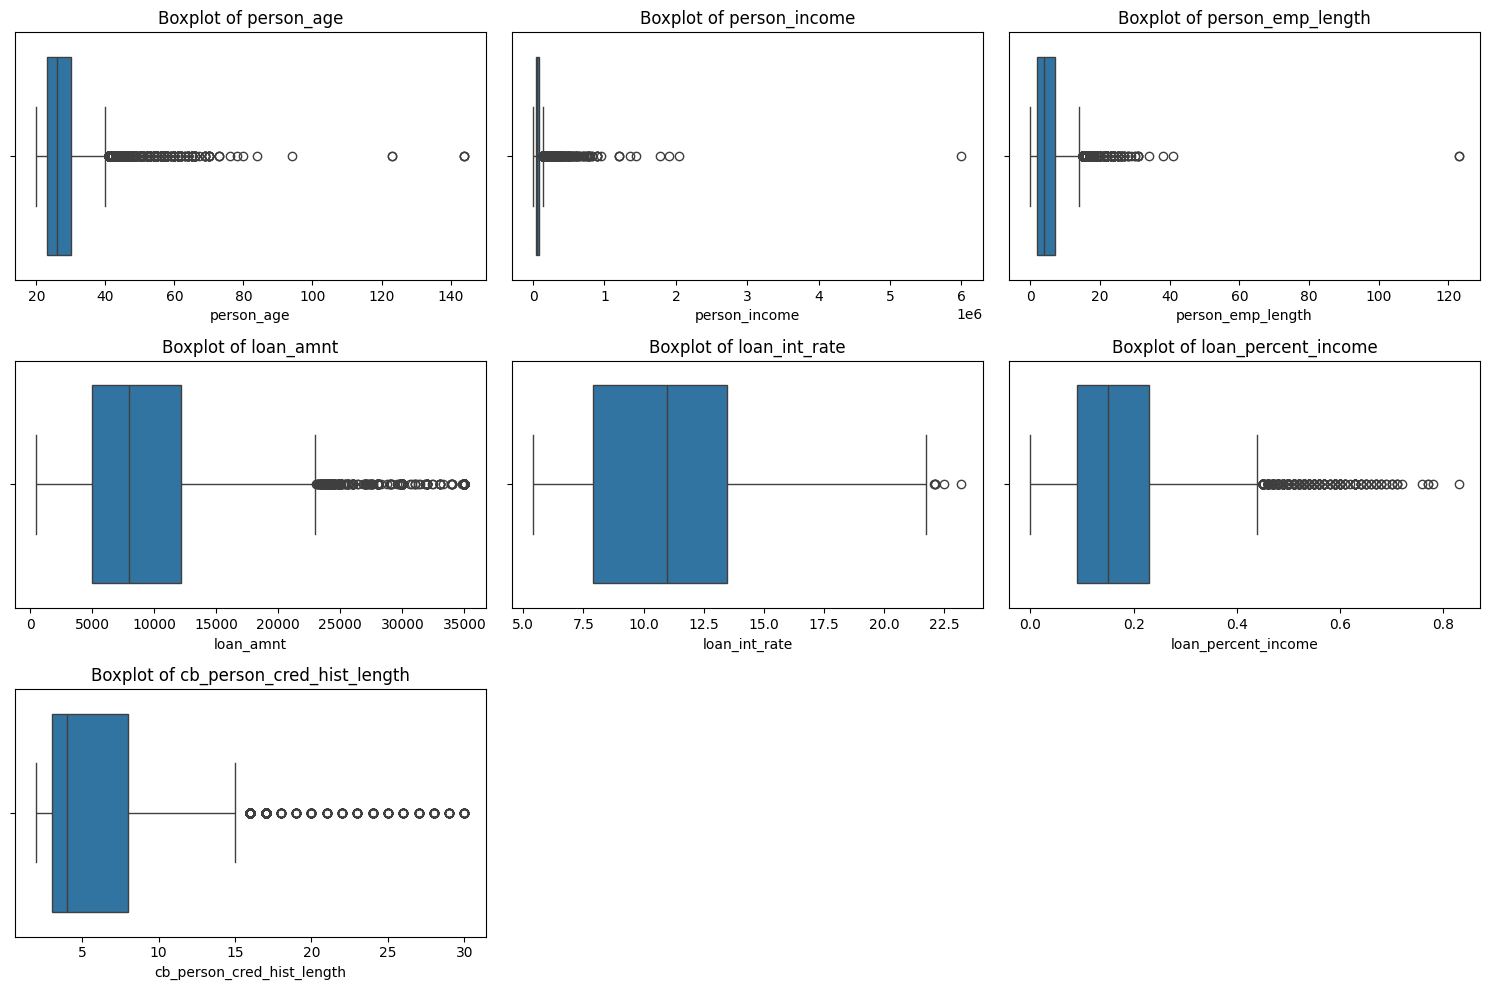

In [10]:

numerical_cols = [
    'person_age', 
    'person_income', 
    'person_emp_length', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [11]:

df = df[df['person_age'] <= 100]
df = df[df['person_emp_length'] <= 60]


df = df[df['person_emp_length'] < df['person_age']]

income_cap = df['person_income'].quantile(0.99)
df = df[df['person_income'] <= income_cap]

print(f"Dataset size after outlier removal: {len(df)}")

Dataset size after outlier removal: 32250


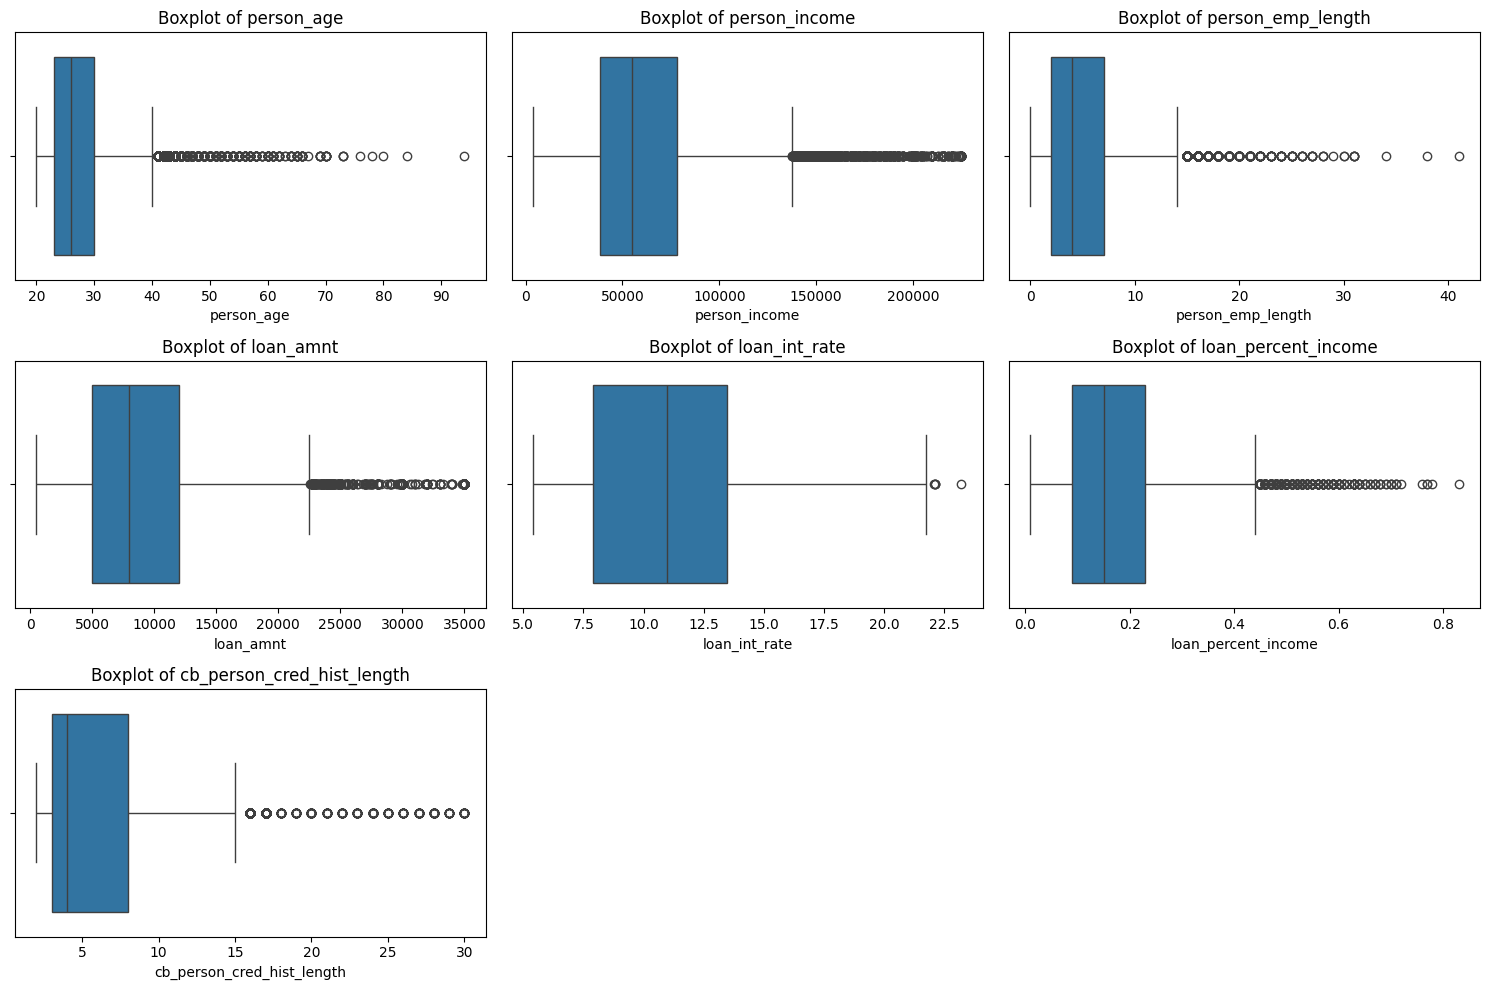

In [12]:
numerical_cols = [
    'person_age', 
    'person_income', 
    'person_emp_length', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [13]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


Feature Engineering

In [14]:
# ==========================================
# FEATURE ENGINEERING WITH INTERACTION FEATURES
# ==========================================

# 1. DTI Ratio (Debt-to-Income) - Already calculated
df['dti_ratio'] = df['loan_amnt'] / df['person_income']

# 2. Income-to-Loan Ratio - How many times loan fits in annual income
df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']

# 3. Credit-History-to-Age Ratio - Credit building relative to age
df['credit_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']

# 4. Income-Credit Score Product - Combined income & creditworthiness signal
# First map loan_grade to numeric score
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['loan_grade_numeric'] = df['loan_grade'].map(grade_map)

# Create interaction: Higher income + Better grade = Lower risk
df['income_credit_product'] = df['person_income'] * (8 - df['loan_grade_numeric'])

# 5. Employment Stability Score - Longer employment = More stable
df['employment_stability'] = df['person_emp_length'] / df['person_age']

# 6. Loan Burden Score - Interest * Loan / Income
df['loan_burden'] = (df['loan_int_rate'] * df['loan_amnt']) / df['person_income']

# Map loan_grade for modeling
df['loan_grade'] = df['loan_grade_numeric']
df = df.drop(columns=['loan_grade_numeric'])

# Separate features and target
target_col = 'loan_status'
x = df.drop(columns=[target_col])
y = df[target_col]

print("✅ New Interaction Features Created:")
print("  - income_to_loan_ratio")
print("  - credit_hist_to_age_ratio")
print("  - income_credit_product")
print("  - employment_stability")
print("  - loan_burden")
print(f"\n📊 Total Features: {x.shape[1]}")

✅ New Interaction Features Created:
  - income_to_loan_ratio
  - credit_hist_to_age_ratio
  - income_credit_product
  - employment_stability
  - loan_burden

📊 Total Features: 17


## 🎯 Interaction Features Analysis

**Why are we adding these features?**

1. **income_to_loan_ratio**: Shows affordability - higher ratio = safer borrower
2. **credit_hist_to_age_ratio**: Measures credit experience relative to age
3. **income_credit_product**: Captures combined effect of income & creditworthiness
4. **employment_stability**: Longer employment % of age = more stable
5. **loan_burden**: How much interest payment impacts income

These features help the model understand **relationships** between variables, not just individual values!

C:\Users\hp\AppData\Local\Temp\ipykernel_30380\3508712607.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\Credit-Risk-Scoring\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


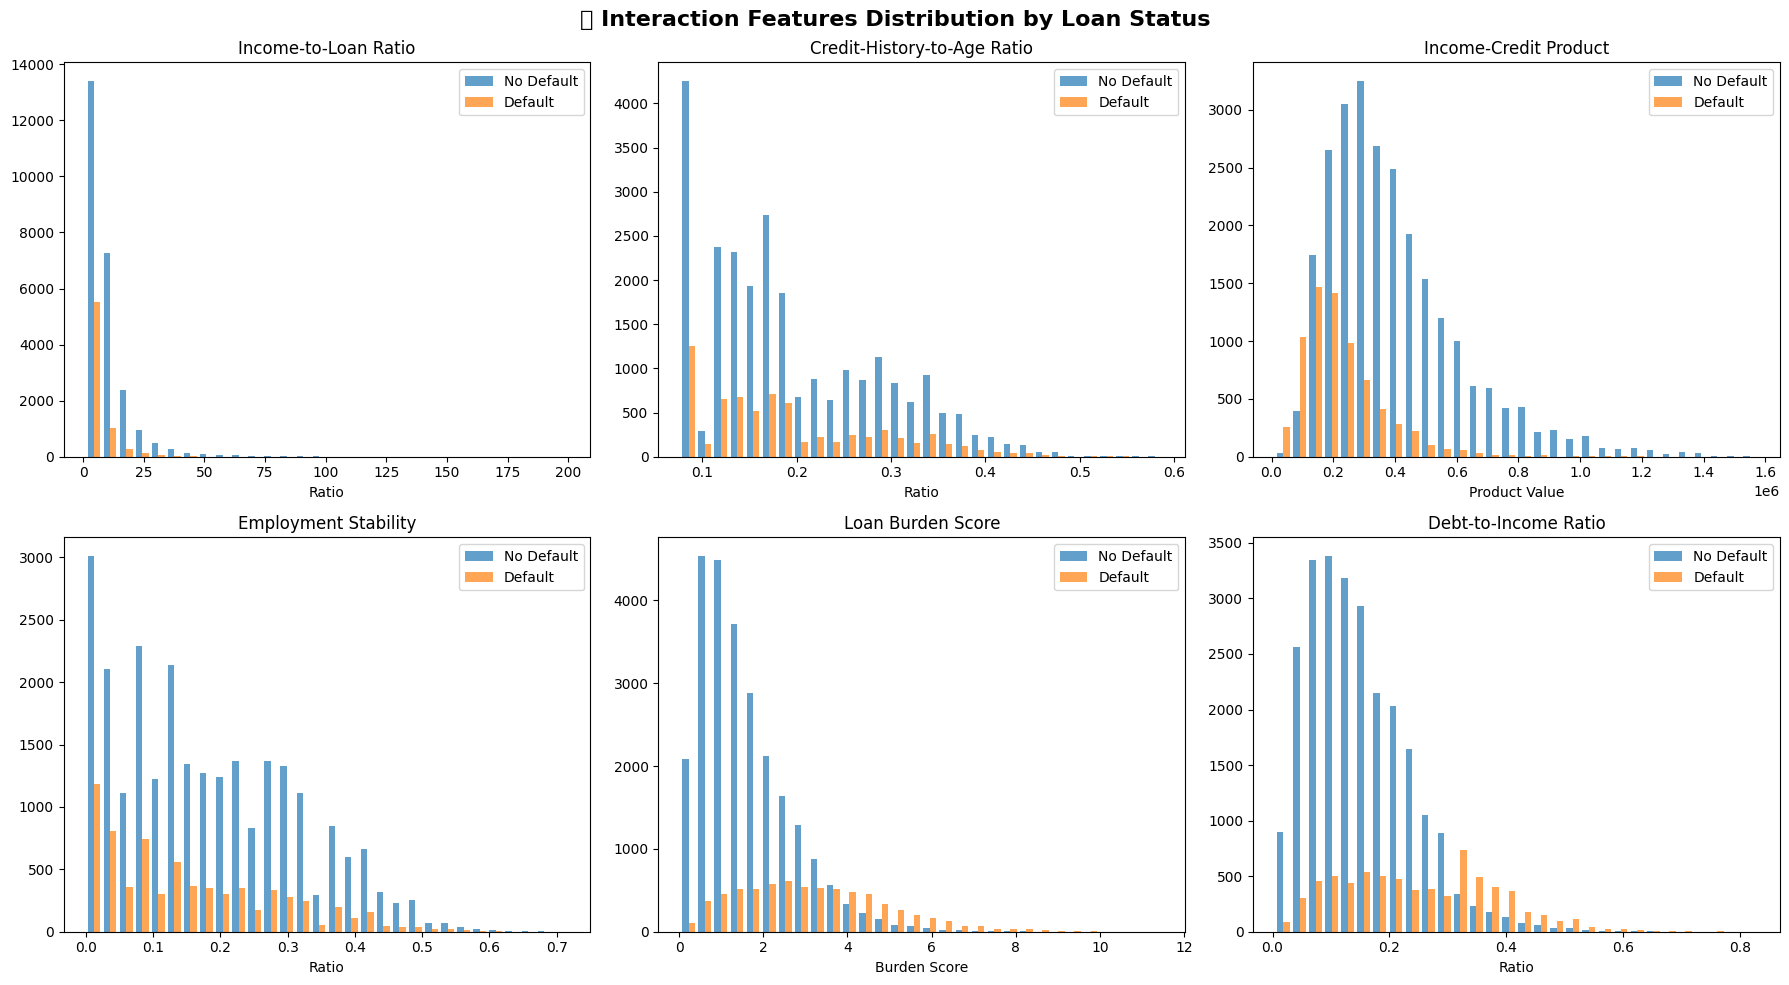

✅ Interaction Features Visualization Complete!


In [15]:
# Visualize New Interaction Features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Interaction Features Distribution by Loan Status', fontsize=16, fontweight='bold')

# 1. Income to Loan Ratio
axes[0, 0].hist([df[df['loan_status']==0]['income_to_loan_ratio'], 
                 df[df['loan_status']==1]['income_to_loan_ratio']], 
                label=['No Default', 'Default'], bins=30, alpha=0.7)
axes[0, 0].set_title('Income-to-Loan Ratio')
axes[0, 0].set_xlabel('Ratio')
axes[0, 0].legend()

# 2. Credit History to Age Ratio
axes[0, 1].hist([df[df['loan_status']==0]['credit_hist_to_age_ratio'], 
                 df[df['loan_status']==1]['credit_hist_to_age_ratio']], 
                label=['No Default', 'Default'], bins=30, alpha=0.7)
axes[0, 1].set_title('Credit-History-to-Age Ratio')
axes[0, 1].set_xlabel('Ratio')
axes[0, 1].legend()

# 3. Income Credit Product
axes[0, 2].hist([df[df['loan_status']==0]['income_credit_product'], 
                 df[df['loan_status']==1]['income_credit_product']], 
                label=['No Default', 'Default'], bins=30, alpha=0.7)
axes[0, 2].set_title('Income-Credit Product')
axes[0, 2].set_xlabel('Product Value')
axes[0, 2].legend()

# 4. Employment Stability
axes[1, 0].hist([df[df['loan_status']==0]['employment_stability'], 
                 df[df['loan_status']==1]['employment_stability']], 
                label=['No Default', 'Default'], bins=30, alpha=0.7)
axes[1, 0].set_title('Employment Stability')
axes[1, 0].set_xlabel('Ratio')
axes[1, 0].legend()

# 5. Loan Burden
axes[1, 1].hist([df[df['loan_status']==0]['loan_burden'], 
                 df[df['loan_status']==1]['loan_burden']], 
                label=['No Default', 'Default'], bins=30, alpha=0.7)
axes[1, 1].set_title('Loan Burden Score')
axes[1, 1].set_xlabel('Burden Score')
axes[1, 1].legend()

# 6. DTI Ratio
axes[1, 2].hist([df[df['loan_status']==0]['dti_ratio'], 
                 df[df['loan_status']==1]['dti_ratio']], 
                label=['No Default', 'Default'], bins=30, alpha=0.7)
axes[1, 2].set_title('Debt-to-Income Ratio')
axes[1, 2].set_xlabel('Ratio')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print("✅ Interaction Features Visualization Complete!")

In [16]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

In [17]:
# Updated Column Transformer with New Interaction Features
transform = ColumnTransformer(
    transformers=[
        ('trf1', OneHotEncoder(handle_unknown='ignore', drop='first'), 
         ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']),
        
        ('trf2', MinMaxScaler(), 
         ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
          'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
          'loan_grade', 'dti_ratio', 
          'income_to_loan_ratio', 'credit_hist_to_age_ratio', 
          'income_credit_product', 'employment_stability', 'loan_burden'])
    ],
    remainder='drop'
)

print("✅ Pipeline Updated with New Features!")

✅ Pipeline Updated with New Features!


In [18]:
x_train_transformed=transform.fit_transform(x_train)

In [19]:
x_test_transformed = transform.transform(x_test)

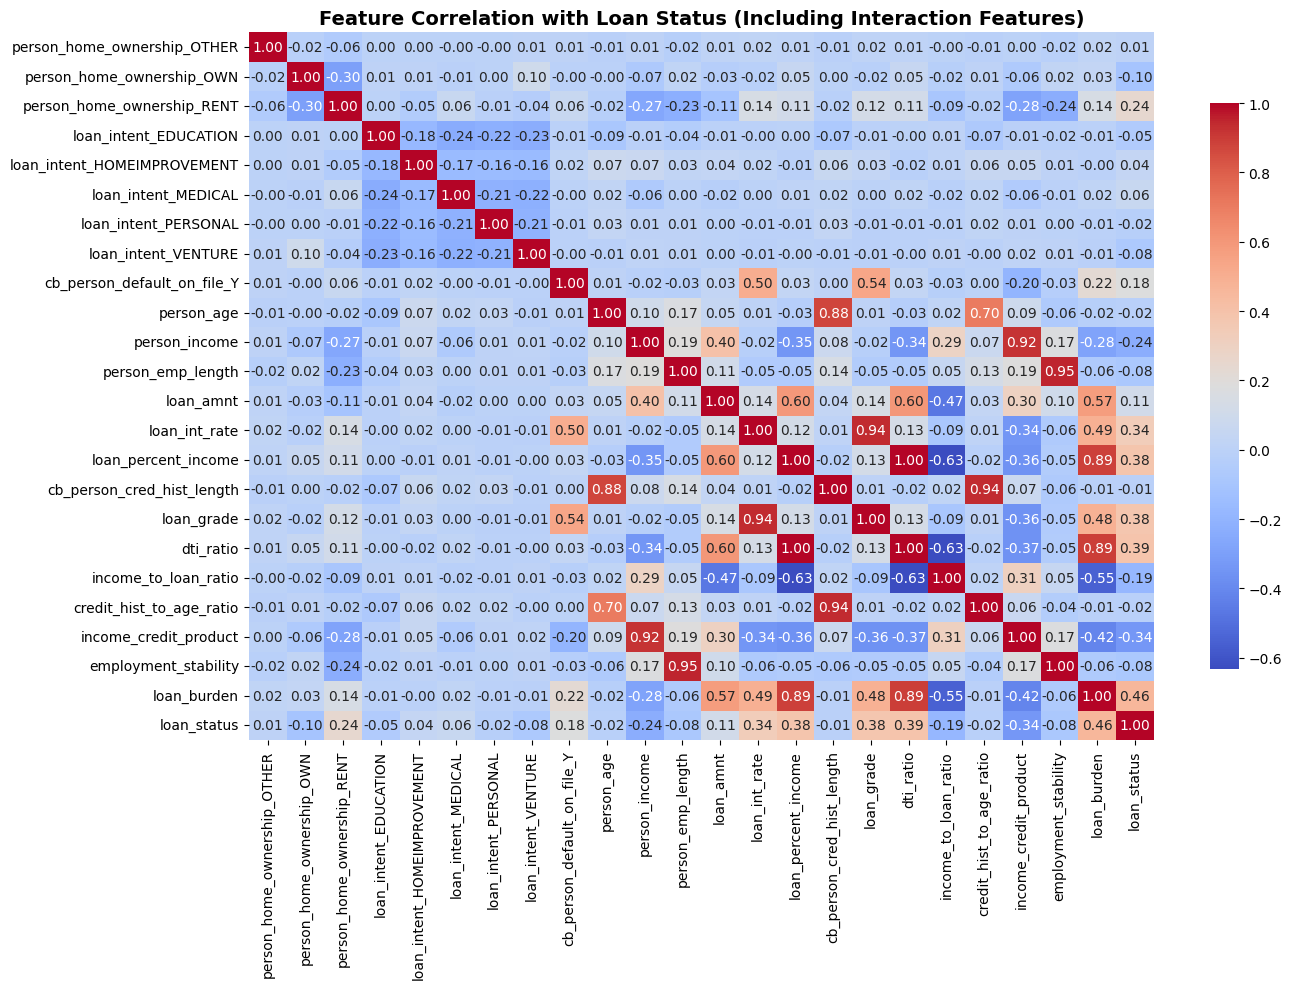


🔥 Correlation Heatmap with NEW Interaction Features Generated!


In [20]:
# Define feature lists with NEW interaction features
categorical_features = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
numerical_features = [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    'loan_grade', 'dti_ratio',
    'income_to_loan_ratio', 'credit_hist_to_age_ratio', 
    'income_credit_product', 'employment_stability', 'loan_burden'
]

# Get feature names from the fitted transformer
categorical_feature_names = transform.named_transformers_['trf1'].get_feature_names_out(categorical_features).tolist()
feature_names = categorical_feature_names + numerical_features

# Convert transformed arrays back to DataFrame for visualization
x_train_df = pd.DataFrame(x_train_transformed, columns=feature_names)
train_data = pd.concat([x_train_df, y_train.reset_index(drop=True)], axis=1)

plt.figure(figsize=(14, 10))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation with Loan Status (Including Interaction Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔥 Correlation Heatmap with NEW Interaction Features Generated!")

In [21]:
# Initialize the model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=3,
    random_state=42
)

# Fit the model on transformed training data
model.fit(x_train_transformed, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [22]:
# Create pipeline
pipe = make_pipeline(transform, model)

In [23]:
y_pred = model.predict(x_test_transformed)
y_prob = model.predict_proba(x_test_transformed)[:, 1]

In [24]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(6450,))

In [25]:
y_prob

array([0.45083687, 0.30964127, 0.3707146 , ..., 0.33783707, 0.20300028,
       0.07470348], shape=(6450,), dtype=float32)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5049
           1       0.82      0.77      0.79      1401

    accuracy                           0.91      6450
   macro avg       0.88      0.86      0.87      6450
weighted avg       0.91      0.91      0.91      6450


ROC-AUC Score: 0.9367

Confusion Matrix:
[[4815  234]
 [ 323 1078]]


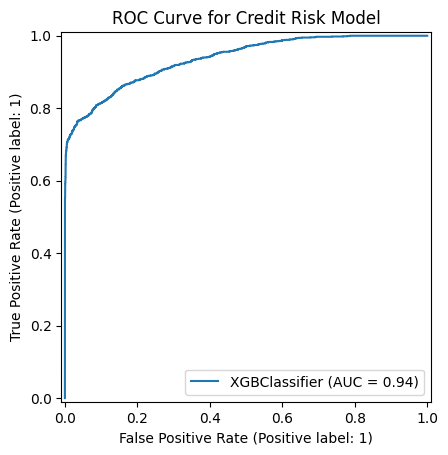

In [26]:

# 1. Standard Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2. AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {auc_score:.4f}")

# 3. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 4. Visualizing the ROC Curve
RocCurveDisplay.from_estimator(model, x_test_transformed, y_test)
plt.title("ROC Curve for Credit Risk Model")
plt.show()

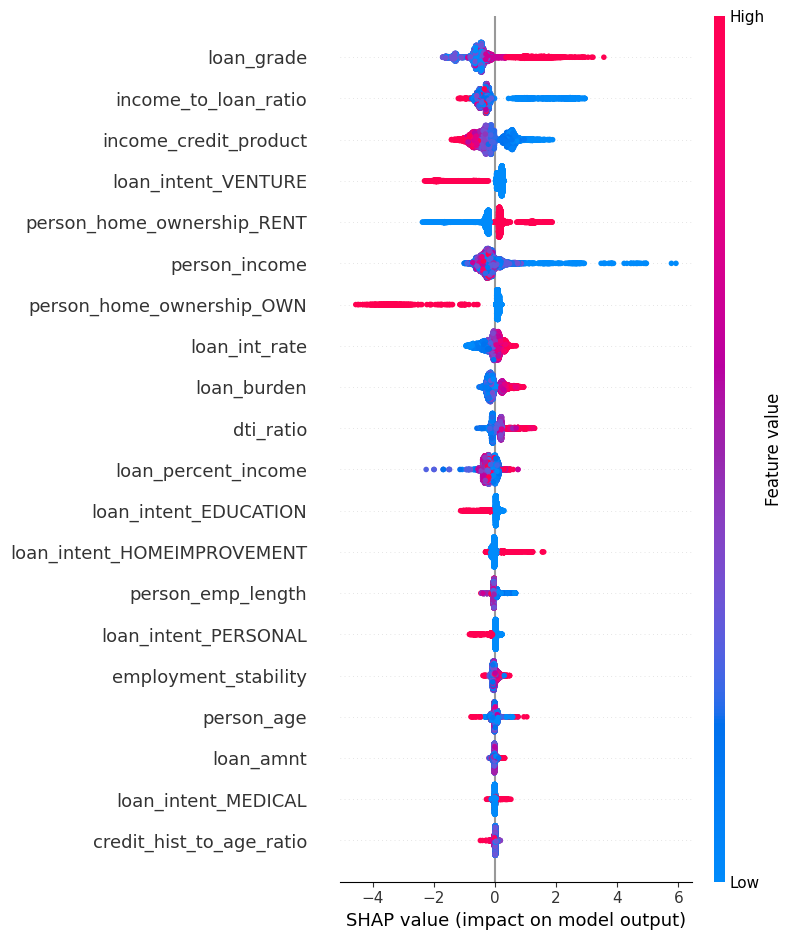

In [27]:

# Calculate SHAP values for the test set
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_transformed)

# Convert transformed test data to DataFrame with feature names for better visualization
x_test_df = pd.DataFrame(x_test_transformed, columns=feature_names)

# Visualize feature importance
shap.summary_plot(shap_values, x_test_df)

In [30]:
joblib.dump(pipe,'E:/Credit-Risk-Scoring/models/credit_risk_pipeline.pkl')

['E:/Credit-Risk-Scoring/models/credit_risk_pipeline.pkl']